# Lab 5: A Black-Box Adversarial Attack
In this lab, we'll carry out an adversarial attack in the **black box** case: we don't have the weights of the network we're trying to trick (the **target model**), and instead we can only give it inputs and see its outputs.

Black-box adversarial attacks are based on the fact that adversarial examples are _transferable_: if it tricks one network, it will likely trick another (but less well).
So, since we need network weights to make adversarial examples, we train a second model, the **surrogate model**, to act like the target model.
To do this, we'll use the target model as an "oracle" to make a dataset where the features are from real examples, and the labels are the outputs of the target model on those examples.
If the surrogate model learns to output the same probabilities as the target model on a given input, its internal representations are likely similar.
Then, when we make an adversarial example for the surrogate model, it should also trick the target model.

The end result of this lab should be an image which looks close to some image in the dataset, but tricks the target network into assigning high confidence to some other class. 

## Section 0: Load the data
This uses the same dataset as last time, so just copy the data over here in the same format.
The same data loading and preprocessing as before is in place.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Seed numpy rng for reproducibility
np.random.seed(1337)

# Load data
x_all = np.load('../lab_4_conv_nets/data/X.npy')
y_all = np.load('../lab_4_conv_nets/data/Y.npy')

# Maps dataset-provided label to true label
label_map = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}

# Correct dataset labels
for row in range(y_all.shape[0]):
    dataset_label = np.where(y_all[row])[0][0]
    y_all[row, :] = np.zeros(10)
    y_all[row, label_map[dataset_label]] = 1
    
# Shuffle features and targets together
# Credit for this technique to:
# https://stackoverflow.com/questions/4601373/
# better-way-to-shuffle-two-numpy-arrays-in-unison
rng_state = np.random.get_state()
np.random.shuffle(x_all)
np.random.set_state(rng_state)
np.random.shuffle(y_all)

# Add a dummy channel axis to input images
x_all = np.expand_dims(x_all, axis=-1)

# Center and rescale data to the range [-1, 1]
x_all = x_all - 0.5
x_all = x_all * 2

# Create a validation set from 30% of the available data
n_points = x_all.shape[0]
n_test = int(n_points * 0.3)
n_train = n_points - n_test
x_train, x_test = np.split(x_all, [n_train], axis=0)
y_train, y_test = np.split(y_all, [n_train], axis=0)

## Section 1: Train the black-box model
Below, I've written a CNN in Keras to classify images from the dataset, and the code to train it.
This will act as the "black box model."

Train the model using the code below.
It should hit about 95-96% validation accuracy on the dataset.

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D

inputs = Input(shape=(64, 64, 1))
layer = Conv2D(16, 5, strides=(2, 2), activation='relu')(inputs)
layer = Conv2D(16, 3, activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Conv2D(32, 3, activation='relu')(layer)
layer = Conv2D(32, 3, activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
layer = MaxPool2D()(layer)

layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
probs = Dense(10, activation='softmax')(layer)

target_model = Model(inputs, probs)
target_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0     

In [4]:
from tensorflow.keras.optimizers import Adam

opt = Adam(1e-3)
target_model.compile(opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
target_model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test),
                 epochs=15)

Epoch 1/15
46/46 [==============================] - 2s 42ms/step - loss: 2.1694 - accuracy: 0.1898 - val_loss: 1.4026 - val_accuracy: 0.5761
Epoch 2/15
46/46 [==============================] - 2s 38ms/step - loss: 0.9021 - accuracy: 0.6988 - val_loss: 0.6220 - val_accuracy: 0.7994
Epoch 3/15
46/46 [==============================] - 2s 35ms/step - loss: 0.4815 - accuracy: 0.8518 - val_loss: 0.3852 - val_accuracy: 0.8851
Epoch 4/15
46/46 [==============================] - 2s 35ms/step - loss: 0.3080 - accuracy: 0.9037 - val_loss: 0.3645 - val_accuracy: 0.8981
Epoch 5/15
46/46 [==============================] - 2s 35ms/step - loss: 0.2107 - accuracy: 0.9314 - val_loss: 0.4439 - val_accuracy: 0.8803
Epoch 6/15
46/46 [==============================] - 2s 34ms/step - loss: 0.1476 - accuracy: 0.9488 - val_loss: 0.2214 - val_accuracy: 0.9353
Epoch 7/15
46/46 [==============================] - 2s 35ms/step - loss: 0.0919 - accuracy: 0.9730 - val_loss: 0.2233 - val_accuracy: 0.9466
Epoch 8/15
46

## Section 2: Build an "oracle dataset" and data pipeline
Now, we'll treat the target model as a black box: pretend we don't have access to its weights or its original input data.
In the wild, all we can do is give it inputs and see its outputs.

We want to train a surrogate model to act similarly to the target model, so create a fake "oracle dataset" where the features are `x_all` and the outputs are the 10-vectors of probability the target model predicts for that input.

Then, set up any `tf.data.Dataset` objects you need.
In this case we don't have a test set, just a training set. Add `tf.summary.SummaryWriter`s to save logs to `./logs/surrogate` and `./logs/adversarial`.

In [6]:
# Feed input features to the model and obtain output labels
y_or = target_model(x_all)

In [16]:
np.shape(y_or)

TensorShape([2062, 10])

In [17]:
np.shape(x_all)

(2062, 64, 64, 1)

In [8]:
batch_size = 32
n_examples = x_all.shape[0]


dataset = tf.data.Dataset.from_tensor_slices((x_all, y_or))\
                .batch(batch_size).shuffle(n_examples).cache()

writer = tf.summary.create_file_writer('../../logs/lab_5_logs/train')

## Section 3: Build a surrogate model
The surrogate model is designed to act similarly to the target model, so that adversarial examples we create for it will also work on the target model.
Feel free to use any architecture you want, but matching the target architecture closely (maybe with a bit more capacity) is a good bet.

Copy code from last week's assignment liberally.
Most likely, you won't have to write all that much new code in this section.

This should involve tensors that:
 - Act as hidden convolutional and dense layers
 - Compute the logits and probabilities for a batch of input images
 - Compute the predicted digit from the probabilities
 - Compute the mean cross-entropy loss over a batch

### 3.1 Dense and convolutional layers
Copy the `Dense` and `Conv` classes you wrote last week here. You will need them to construct the graph of your surrogate model.

In [9]:
class Dense(tf.Module):
    def __init__(self, dim_input, dim_output, do_activation=True, postfix='', name=None):
        super().__init__(name=name)
        with tf.name_scope('dense' + postfix):
            self.weights = tf.Variable(tf.initializers.glorot_uniform()(shape=(dim_input, dim_output), dtype=tf.float32), \
                                      name='weights')
            self.bias = tf.Variable(tf.zeros_initializer()(shape=(dim_output,), dtype=tf.float32), name='bias')
            self.activation = do_activation
            
    def __call__(self, x):
        # Assuming x has shape (n_examples, dim_input)
        y = tf.matmul(x, self.weights)
        # prod shape: (n_examples, dim_output)
        # bias shape: (dim_output,)
        # bias should be broadcasted over all examples
        y += self.bias
        if self.activation:
            y = tf.nn.relu(y)
        # out shape: (n_examples, dim_output)
        return y

class Conv(tf.Module):
    '''
    Creates a convolutional layer module.
    
    Parameters
    ----------
    input_channels: int
        Number of channels in the input representation.
    n_filters: int
        Number of channels in the output representation.
        Equivalently, number of filters in this layer.
    filter_size: int
        Width and height of each kernel in the layer's filters.
    stride: int
        Stride to use in the x and y directions for the
        convolution operation.
    do_activation: bool
        Whether or not to apply ReLU activation.
    pool_size: int
        If > 1, does max pooling of this size to the
        width and height axes of the activation.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
    name: string
        Name of layer
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    def __init__(self, input_channels, n_filters, 
                 filter_size=3, stride=1,
                 do_activation=True, pool_size=1,
                 postfix='', name=None):
        super().__init__(name=name)
        with tf.name_scope('conv' + postfix):
            self.stride = stride
            self.do_activation = do_activation
            self.pool_size = pool_size
            
            self.filters = tf.Variable(tf.initializers.glorot_uniform()\
                                       (shape=(filter_size, filter_size, input_channels, n_filters)),\
                                       name='filters')
            # Just gets broadcasted when adding to (n_examples(?), n_filters, img_size, img_size)?
            self.biases = tf.Variable(tf.initializers.glorot_uniform()(shape=(n_filters,)))
            
    # Might want the unpooled image at some point
    def image(self, x):
        # x shape: (batch_size, x_size, x_size, n_channels)
        # filters shape: (n_filters, ker_size, ker_size, n_channels)
        # need stride lengths along each dimension of x
        x = tf.nn.conv2d(x, self.filters, (1, self.stride, self.stride, 1), padding='SAME')
        # x shape: (batch_size, x_size, x_size, n_filters)
        x += self.biases
        if self.do_activation:
            x = tf.nn.relu(x)
        return x
            
    def __call__(self, x):
        x = self.image(x)
        if self.pool_size > 1:
            x = tf.nn.max_pool(x, ksize=self.pool_size, strides=self.pool_size, padding='VALID')
        return x

### 3.2: The rest of the model
Write a `tf.Module` class called `Surrogate` that uses your classes from last week to be your surrogate model.

#### 3.2.1: Adversarial noise
This is the only part of the model that really differs from last week, and it's a bit tricky.

Add a variable to the graph that represents the adversarial noise we'll add to one example.
It should be the shape of a single input image and initialized to zeros.
In addition, pass (to the `Variable()` constructor) the keyword argument `constraint=lambda x: tf.clip_by_value(x, -0.3, 0.3)`.
Every time the variable is updated, it will become the result of the lambda function, which in this case constrains its pixel values to be in the range -0.3 to 0.3.
(Equivalently, at every step we re-project the adversarial noise back into a hypercube at the origin with side length 0.6).
I found that 0.3 works well, but feel free to change this value -- smaller values will produce less obvious noise, while larger values will produce more successful attacks. 

Add a boolean `tf.Variable` (default False) named "use_noise" to the graph.
This will act as a "switch" controlling whether a given run uses adversarial noise. Additionally, add the argument `trainable=False` to the constructor, as it makes no sense to update this variable during training.

Add a `tf.cond()` operation that, depending on `use_noise`, switches between the input image and the image plus the adversarial noise.
This allows us to train the surrogate model without adversarial noise, then enable it when crafting the adversarial example.

In [10]:
x = tf.Variable(tf.zeros((64, 64, 1)))

In [38]:
# inputs = Input(shape=(64, 64, 1))
# layer = Conv2D(16, 5, strides=(2, 2), activation='relu')(inputs)
# layer = Conv2D(16, 3, activation='relu')(layer)
# layer = MaxPool2D()(layer)

# layer = Conv2D(32, 3, activation='relu')(layer)
# layer = Conv2D(32, 3, activation='relu')(layer)
# layer = MaxPool2D()(layer)

# layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
# layer = Conv2D(64, 3, padding='same', activation='relu')(layer)
# layer = MaxPool2D()(layer)

# layer = Flatten()(layer)
# layer = Dense(128, activation='relu')(layer)
# probs = Dense(10, activation='softmax')(layer)

class Surrogate(tf.Module):
    def __init__(self, use_noise=False, name=None):
        self.noise = tf.Variable(tf.zeros((64, 64, 1)), constraint=lambda x: tf.clip_by_value(x, -0.3, 0.3))
        self.use_noise = tf.Variable(use_noise, trainable=False)

        # Put convolutional and dense layers here.
        # input shape: (n_examples, 64, 64, 1)
        self.conv_1 = Conv(1, 16, filter_size=5, stride=2, postfix='_1')
        self.conv_2 = Conv(16, 16, filter_size=3, pool_size=2, postfix='_2')
        # out shape: (n_examples, 32, 32, 16)
        
        self.conv_3 = Conv(16, 32, filter_size=3, postfix='_3')
        self.conv_4 = Conv(32, 32, filter_size=3, pool_size=2, postfix='_4')
        # out shape: (n_examples, 16, 16, 32)
        
        self.conv_5 = Conv(32, 64, filter_size=3, postfix='_4')
        self.conv_6 = Conv(64, 64, filter_size=3, pool_size=2, postfix='_4')
        # out shape: (n_examples, 8, 8, 64)
        
        self.dense_1 = Dense(4 * 4 * 64, 128, postfix='_1')
        self.dense_2 = Dense(128, 10, do_activation=False, postfix='_2')
        
    def logits(self, x):
        x = tf.cond(self.use_noise, lambda: tf.add(x, self.noise), lambda: x)

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.conv_6(x)
        # out shape: (32, 4, 4, 64)
        
        # -1 is inferred to be batch size
        # batch size goes from 32 to 16, here.
        x = tf.reshape(x, [-1, 4 * 4 * 64])
        # out shape: (16, 2048)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return x
    
    @tf.function
    def __call__(self, x):
        x = self.logits(x)
        x = tf.nn.softmax(x)
        return x

### 3.3: Compute cross-entropy loss
Write a `_loss` function to compute the cross-entropy loss.

In [12]:
def _loss(target, actual):
    loss_per_example = tf.nn.softmax_cross_entropy_with_logits(target, actual)
    loss_batch = tf.reduce_mean(loss_per_example)
    return loss_batch

### 3.4: Surrogate and adversarial loss and gradients
Add an optimizer and train method we'll use to train the surrogate model to act like the target model.
It should just minimize the cross-entropy loss between the model's predictions and the targets. When `use_noise` is false, we will not have any gradients to update the adversarial noise tensor with because it will not be referenced in our computation. This will cause TensorFlow to throw (very annoying) warning messages about nonexistent gradients. To suppress this, we can use this neat trick (credit [here](https://stackoverflow.com/questions/60022462/how-to-suppress-specific-warning-in-tensorflow-python)) to preprocess our gradients,
```
gradients = g.gradient(loss, model.trainable_variables)
surrogate_optimizer.apply_gradients( 
                            (grad, var) for (grad, var) in zip(gradients, model.trainable_variables)
                             if grad is not None)
```

When training the surrogate model, we want to change the model parameters to minimize the loss.
When creating the adversarial example, we want to do something very different: _change the adversarial noise tensor alone to maximize the loss_.

So, add an `adversarial=False` argument to your train method so we can toggle whether or not to train the surrogate model, or the adversarial noise.

Define a new adversarial loss which is the negative of the original loss, and a new optimizer to minimize it.
When you call `minimize()`, pass in the keyword argument `var_list=[model.noise]`, where "noise" is the name of your adversarial noise tensor.
This will prevent the optimizer from changing the weights of the model when we optimize the adversarial noise.

Add a summary scalar to plot the adversarial loss decreasing. Then, add a summary histogram and a summary image for the adversarial noise tensor, so we can plot it as we're learning the adversarial example.
Finally, add a summary image for the output of `cond`, which will be our adversarial example later.

In [ ]:
def _accuracy(x_hat, y):
    actual = tf.argmax(x_hat, axis=1)
    target = tf.argmax(y, axis=1)
    comp = tf.math.equal(target, actual)
    comp = tf.cast(comp, dtype=tf.float32)
    accuracy = tf.reduce_mean(comp)
    return accuracy

def train(model, optimizer, x, y, i, adversarial=False):
    if not adversarial:
        with tf.GradientTape() as g:
            # WHY don't we use the probabilities, again?
            # cross entropy with logits does the softmax for us
            logits = model.logits(x)
            # print(np.shape(logits), np.shape(y))
            loss = _loss(y, logits)

        gradients = g.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients((grad, var) for (grad, var) in zip(gradients, model.trainable_variables)
                         if grad is not None)

        x_hat = model(x)
        accuracy = _accuracy(x_hat, tf.cast(y, dtype=tf.float32))

        with writer.as_default():
            tf.summary.scalar('training_loss', loss, step=i)
            tf.summary.scalar('training_accuracy', accuracy, step=i)
        return loss, accuracy
                

    else:
        with tf.GradientTape() as g:
            # WHY don't we use the probabilities, again?
            # cross entropy with logits does the softmax for us
            adv_loss = -1 * _loss(y, model.logits(x))
            
        var_list = [model.noise]
        gradients = g.gradient(adv_loss, var_list)
        optimizer.apply_gradients(zip(gradients, var_list))
        
        x_hat = model(x)
        accuracy = _accuracy(x_hat, tf.cast(y, dtype=tf.float32))
        
        with writer.as_default():
            tf.summary.scalar('adv_loss', adv

In [51]:
def _accuracy(x_hat, y):
    actual = tf.argmax(x_hat, axis=1)
    target = tf.argmax(y, axis=1)
    comp = tf.math.equal(target, actual)
    comp = tf.cast(comp, dtype=tf.float32)
    accuracy = tf.reduce_mean(comp)
    return accuracy

def train(model, optimizer, x, y, i, adversarial=False):
    if not adversarial:
        with tf.GradientTape() as g:
            # WHY don't we use the probabilities, again?
            # cross entropy with logits does the softmax for us
            logits = model.logits(x)
            # print(np.shape(logits), np.shape(y))
            loss = _loss(y, logits)

        gradients = g.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients((grad, var) for (grad, var) in zip(gradients, model.trainable_variables)
                         if grad is not None)

        x_hat = model(x)
        accuracy = _accuracy(x_hat, tf.cast(y, dtype=tf.float32))

        with writer.as_default():
            tf.summary.scalar('training_loss', loss, step=i)
            tf.summary.scalar('training_accuracy', accuracy, step=i)
        return loss, accuracy
                

    else:
        with tf.GradientTape() as g:
            # WHY don't we use the probabilities, again?
            # cross entropy with logits does the softmax for us
            adv_loss = -1 * _loss(y, model.logits(x))
            
        var_list = [model.noise]
        gradients = g.gradient(adv_loss, var_list)
        optimizer.apply_gradients(zip(gradients, var_list))
        
        x_hat = model(x)
        accuracy = _accuracy(x_hat, tf.cast(y, dtype=tf.float32))
        
        with writer.as_default():
            tf.summary.scalar('adv_loss', adv_loss, step=i)
        return adv_loss, accuracy

## Section 4: Train the surrogate model
Train your surrogate model until it hits high accuracy.
At the very least it should have 90% accuracy -- I hit 98-100% on the training set.
Overfitting isn't really a concern here since we are actually trying to memorize the target model.

When the training loop is done, save the model under `./checkpoints/model_surrogate`.
We won't be modifying this particular checkpoint any more, it'll contain the fully-trained surrogate model with zero adversarial noise.

In [48]:
optimizer = tf.optimizers.SGD(1e-3, momentum=0.9)

model = Surrogate()
batch = 0
n_epochs = 50

for i in range(n_epochs):
    losses = []
    accuracies = []
    for x, y in dataset:
        # print(np.shape(x), np.shape(y))
        if batch == 0:
            tf.summary.trace_on(graph=True, profiler=True)
            with writer.as_default():
                tf.summary.trace_export(name='first training batch', step=0, profiler_outdir='../../logs/lab_5_logs')
        loss, accuracy = train(model, optimizer, x, y, batch)
        losses.append(loss)
        accuracies.append(accuracy)
        batch += 1

    print('Epoch\t', i)
    print('Average Loss:\t', np.mean(losses))
    print('Average Accuracy:\t', np.mean(accuracy))
    
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write('../../logs/lab_5_checkpoints')

Epoch	 0
Average Loss:	 2.3061082
Average Accuracy:	 0.15625
Epoch	 1
Average Loss:	 2.3031814
Average Accuracy:	 0.15625
Epoch	 2
Average Loss:	 2.3022132
Average Accuracy:	 0.15625
Epoch	 3
Average Loss:	 2.3011086
Average Accuracy:	 0.15625
Epoch	 4
Average Loss:	 2.2998402
Average Accuracy:	 0.15625
Epoch	 5
Average Loss:	 2.2982323
Average Accuracy:	 0.15625
Epoch	 6
Average Loss:	 2.29591
Average Accuracy:	 0.15625
Epoch	 7
Average Loss:	 2.292413
Average Accuracy:	 0.125
Epoch	 8
Average Loss:	 2.287163
Average Accuracy:	 0.21875
Epoch	 9
Average Loss:	 2.2788064
Average Accuracy:	 0.25
Epoch	 10
Average Loss:	 2.265797
Average Accuracy:	 0.21875
Epoch	 11
Average Loss:	 2.241939
Average Accuracy:	 0.3125
Epoch	 12
Average Loss:	 2.1892462
Average Accuracy:	 0.3125
Epoch	 13
Average Loss:	 2.0436065
Average Accuracy:	 0.3125
Epoch	 14
Average Loss:	 1.664696
Average Accuracy:	 0.53125
Epoch	 15
Average Loss:	 1.1665877
Average Accuracy:	 0.65625
Epoch	 16
Average Loss:	 0.857579

'../../logs/lab_5_checkpoints'

## Section 5: Learn the adversarial example
Finally, it's time to create an adversarial example using our surrogate model.
Pick an image from the test set (or use the one I picked below), then run a training loop to minimize the adversarial loss (equivalently, maximize the model loss on that example).
To do this, use `surrogate_model.use_noise.assign(True)`.
This turns on the `use_noise` switch we set before, and overwrites the input image with the image we're going to turn into an adversarial example.

When it's done, save it to a new checkpoint, `./checkpoints/model_adversarial`.
This new checkpoint should have exactly the same model parameters as before (remember that we're only optimizing the noise), but a nonzero noise tensor.

At the end, also save the adversarial example (which will be contained in the result of your `cond`) and the noise tensor to a numpy array so we can use them later.

Periodically write the image and histogram summaries so you can look at them in TensorBoard later. 

You should be able to do this just by setting `adversarial=True` in your train method.

Text(0.5, 1.0, 'True label: 9')

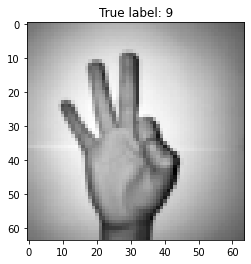

In [49]:
# Pick and plot the image we'll turn into an adversarial example
idx = 1
img = x_test[idx]
lbl = y_test[idx]

plt.imshow(img[:, :, 0], cmap='gray')
plt.title('True label: {}'.format(np.argmax(lbl)))

In [54]:
# We want to train the same model that we just trained above to screw up.
# Do we use the same optimizer? I don't think we have to, because the saved weights are in the model.

model.use_noise.assign(True)
optimizer = tf.optimizers.SGD(5e-2, momentum=0.9)

batch = 0
n_epochs = 50

for i in range(n_epochs):
    losses = []
    accuracies = []
    for x, y in dataset:
        if batch == 0:
            tf.summary.trace_on(graph=True, profiler=True)
            with writer.as_default():
                tf.summary.trace_export(name='first training batch', step=0, profiler_outdir='../../logs/lab_5_logs/adv')
        loss, accuracy = train(model, optimizer, x, y, batch, adversarial=True)
        losses.append(loss)
        accuracies.append(accuracy)
        batch += 1

    print('Epoch\t', i)
    print('Average Loss:\t', -1 * np.mean(losses))
    print('Average Accuracy:\t', np.mean(accuracy))
    
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write('../../logs/lab_5_checkpoints/adv')

Epoch	 0
Average Loss:	 0.3548084497451782
Average Accuracy:	 0.4375
Epoch	 1
Average Loss:	 21.216365814208984
Average Accuracy:	 0.125
Epoch	 2
Average Loss:	 32.19492721557617
Average Accuracy:	 0.09375
Epoch	 3
Average Loss:	 33.2396125793457
Average Accuracy:	 0.09375
Epoch	 4
Average Loss:	 33.57716751098633
Average Accuracy:	 0.09375
Epoch	 5
Average Loss:	 33.737220764160156
Average Accuracy:	 0.09375
Epoch	 6
Average Loss:	 33.81489944458008
Average Accuracy:	 0.09375
Epoch	 7
Average Loss:	 33.848907470703125
Average Accuracy:	 0.09375
Epoch	 8
Average Loss:	 33.874080657958984
Average Accuracy:	 0.09375
Epoch	 9
Average Loss:	 33.89487075805664
Average Accuracy:	 0.09375
Epoch	 10
Average Loss:	 33.906612396240234
Average Accuracy:	 0.09375
Epoch	 11
Average Loss:	 33.91423416137695
Average Accuracy:	 0.09375
Epoch	 12
Average Loss:	 33.91941833496094
Average Accuracy:	 0.09375
Epoch	 13
Average Loss:	 33.92448043823242
Average Accuracy:	 0.09375
Epoch	 14
Average Loss:	 33.

'../../logs/lab_5_checkpoints/adv'

## Section 6: Visualize the adversarial example
Plot the original example, the adversarial example, and the adversarial noise below.

In [ ]:
# Your code here

## Section 7: Demonstrate that the surrogate model fails on the adversarial example
Compute the surrogate model's prediction and probability for the original example and the adversarial example, and compare them. Remember to set the `use_noise` switch to false when computing predictions.

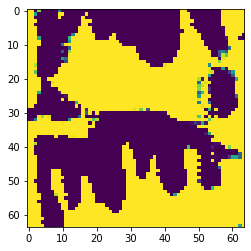

In [70]:
noise = model.noise[:, :, 0]
plt.imshow(noise)

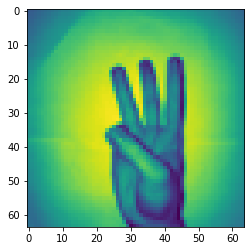

In [85]:
example = x_all[10, :, :, 0]
plt.imshow(example)

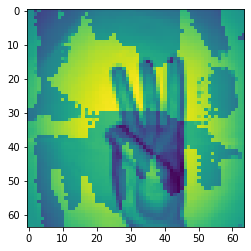

In [86]:
adv_example = example + noise
plt.imshow(adv_example)

In [87]:
print(y_all[10])
print(model(np.reshape(example, [1, 64, 64, 1])))

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
tf.Tensor(
[[1.2810087e-27 1.0000000e+00 9.9703806e-13 3.0369963e-14 1.1613867e-33
  1.4807404e-33 2.1341535e-26 9.8268739e-17 3.3626629e-17 5.0327740e-21]], shape=(1, 10), dtype=float32)


## 8: Demonstrate that the target model fails on the adversarial example
This is the real test -- transferring the learned adversarial example from the surrogate model to the target model.
Compute the target model's prediction and probability for the original example and the adversarial example, and compare them.

In [90]:
ex = np.reshape(example, [1, 64, 64, 1])
adv_ex = np.reshape(adv_example, [1, 64, 64, 1])

In [96]:
ex_probs = target_model(ex)
print(ex_probs)
print(tf.argmax(ex_probs, axis=1))
# The target model correctly classifies the example as the number 6.

tf.Tensor(
[[6.23705643e-10 1.06517436e-13 1.38771281e-06 7.70195001e-08
  1.57073154e-09 2.87712321e-09 9.99998450e-01 9.09846365e-11
  5.29122079e-10 9.78938407e-14]], shape=(1, 10), dtype=float32)
tf.Tensor([6], shape=(1,), dtype=int64)


In [97]:
adv_probs = target_model(adv_ex)
print(adv_probs)
print(tf.argmax(adv_probs, axis=1))
# However, it is fairly confident that the slightly altered adversarial example is a 1 (with its second choice
# being 2).

tf.Tensor(
[[5.3709736e-12 6.2007523e-01 3.7980500e-01 1.9776839e-05 5.2378040e-13
  1.2145458e-12 3.0970819e-09 9.8522549e-05 1.5431453e-06 1.1355083e-13]], shape=(1, 10), dtype=float32)
tf.Tensor([1], shape=(1,), dtype=int64)


# Congratulations, you've carried out a black-box adversarial attack!
These kinds of adversarial attacks are a serious concern in the real world, since they can be [made to work when printed on paper](https://blog.openai.com/robust-adversarial-inputs/) and [we're still bad at defending against them](https://blog.openai.com/adversarial-example-research/).

Some interesting things to try:
 - Did the surrogate model and the target model misclassify the adversarial example in the same way? (Mine did)
 - How subtle can you make the noise while still tricking the target network?
 - Look at how the adversarial example evolves through training in TensorBoard